## Anomaly Detection with Autoencoder (PyTorch Session II)

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from matplotlib import pyplot
from pathlib import Path
import pandas as pd
import pickle
import numpy as np
import plotly.graph_objects as go
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import plotly.graph_objects as px
from collections import Counter
from matplotlib import pyplot as plt
import torch.nn.functional as F
import random

# More Readings on "Reproductivity": https://pytorch.org/docs/stable/notes/randomness.html
def set_seeds():
    RANDOM_SEED = 5
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)
    torch.backends.cudnn.enabled = False 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


## Load Data

In [3]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"
# Dataset used to train and validate
df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True
)
# Dataset used to test
df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True
)

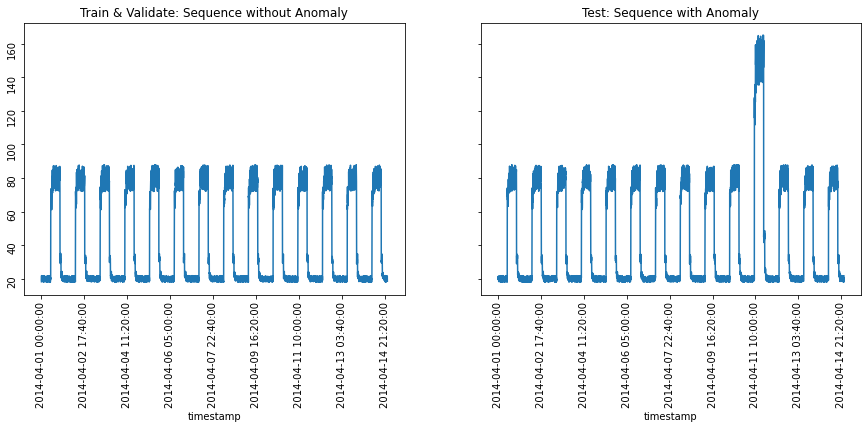

In [4]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5), sharey='row')
df_small_noise.plot(x='timestamp', y='value', legend=False, ax=ax1, title="Train & Validate: Sequence without Anomaly")
ax1.tick_params(labelrotation=90)
df_daily_jumpsup.plot(x='timestamp', y='value',legend=False, ax=ax2, title="Test: Sequence with Anomaly")
ax2.tick_params(labelrotation=90)
plt.show()

In [5]:
df_small_noise.head(5), df_daily_jumpsup.head(5)

(             timestamp      value
 0  2014-04-01 00:00:00  18.324919
 1  2014-04-01 00:05:00  21.970327
 2  2014-04-01 00:10:00  18.624806
 3  2014-04-01 00:15:00  21.953684
 4  2014-04-01 00:20:00  21.909120,
              timestamp      value
 0  2014-04-01 00:00:00  19.761252
 1  2014-04-01 00:05:00  20.500833
 2  2014-04-01 00:10:00  19.961641
 3  2014-04-01 00:15:00  21.490266
 4  2014-04-01 00:20:00  20.187739)

## Pre-processing

In [6]:
# train test 80/20 split
train_test_split_ratio = 0.8
total = len(df_small_noise)
split_index = int(total*train_test_split_ratio)
train, validate = df_small_noise.iloc[:split_index], df_small_noise.iloc[split_index:]
print(f"Train dataset shape: {train.shape}, Validation dataset shape:{validate.shape}")

Train dataset shape: (3225, 2), Validation dataset shape:(807, 2)


In [7]:
scaler = StandardScaler()
scaler = scaler.fit(train[['value']])

In [8]:
scaled_train = train.copy()
scaled_train.loc[:, 'value'] = scaler.transform(train[['value']])

scaled_validate = validate.copy()
scaled_validate.loc[:, 'value'] = scaler.transform(validate[['value']])

## Construct Dataset

In [9]:
#  ---------------  Dataset  ---------------

class AccelerometerDataset(Dataset):
    """Accelerometer dataset."""
        
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        # length of the dataset
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [10]:
batch_size = 5
sequence_length = 30

train_dataset = AccelerometerDataset(
    scaled_train,
    target=['value'],
    features=['value'],
    sequence_length=sequence_length
)


test_dataset = AccelerometerDataset(
    scaled_validate,
    target=['value'],
    features=['value'],
    sequence_length=sequence_length
)


set_seeds()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=np.random.seed(0))
valid_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1, worker_init_fn = np.random.seed(0))

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)



Features shape: torch.Size([5, 30, 1])
Target shape: torch.Size([5, 1])


## Train Model

In [11]:
# Use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda:0


In [12]:
class AutoEncoderLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.encoder = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers, 
            bidirectional=False
        )
        self.decoder = nn.LSTM(
            input_size=hidden_units,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers, 
            bidirectional=False
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units, requires_grad=True).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units, requires_grad=True).to(device)

        ht, (hn, _) = self.encoder(x, (h0, c0))
        # print(ht.shape)
        _, (outhn, _) = self.decoder(ht)
        out = self.linear(outhn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.
        return out.reshape(-1, 1)

In [14]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    

In [15]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0

    for X, y in data_loader:
        model.train()
        inputs = X.to(device)
        labels = y.to(device)
        # Step 1: Compute model's predictions - forward pass
        outputs = model(inputs.float())
        # Step 2: Compute loss
        loss = loss_function(outputs, labels.float())
        # Step 3: Compute the gradients
        loss.backward()
        # Step 4: Update the parameters
        optimizer.step()
        # Step 5: Zero gradient to avoid gradient accumulation
        optimizer.zero_grad()
    
        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss
    

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    with torch.no_grad():
        for X, y in data_loader:
            model.eval()
            
            inputs = X.to(device)
            labels = y.to(device)
            outputs = model(inputs.float())
            total_loss += loss_function(outputs, labels.float()).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

In [16]:
train_mse_loss = []
test_mse_loss = []
num_epochs = 20
num_hidden_units = 10
num_features = 1

set_seeds()

model = AutoEncoderLSTM(num_sensors=num_features, hidden_units=num_hidden_units).to(device)

print(count_parameters(model))
print("\n")
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)


for epoch in range(num_epochs):
    print(f"Epoch {epoch}\n---------")
    train_loss_at_epoch = train_model(train_loader, model, loss_function, optimizer)
    train_mse_loss.append(train_loss_at_epoch)
    test_loss_at_epoch = test_model(valid_loader, model, loss_function)
    test_mse_loss.append(test_loss_at_epoch)
    print()

+----------------------+------------+
|       Modules        | Parameters |
+----------------------+------------+
| encoder.weight_ih_l0 |     40     |
| encoder.weight_hh_l0 |    400     |
|  encoder.bias_ih_l0  |     40     |
|  encoder.bias_hh_l0  |     40     |
| decoder.weight_ih_l0 |    400     |
| decoder.weight_hh_l0 |    400     |
|  decoder.bias_ih_l0  |     40     |
|  decoder.bias_hh_l0  |     40     |
|    linear.weight     |     10     |
|     linear.bias      |     1      |
+----------------------+------------+
Total Trainable Params: 1411
1411


Epoch 0
---------
Train loss: 0.9660269398790922
Test loss: 0.9245063275972634

Epoch 1
---------
Train loss: 0.6226577702303265
Test loss: 0.3457774684568982

Epoch 2
---------
Train loss: 0.20609472597833695
Test loss: 0.15871221897261287

Epoch 3
---------
Train loss: 0.12640302442916662
Test loss: 0.12021321849825642

Epoch 4
---------
Train loss: 0.1027905668344984
Test loss: 0.10185297933065068

Epoch 5
---------
Train los

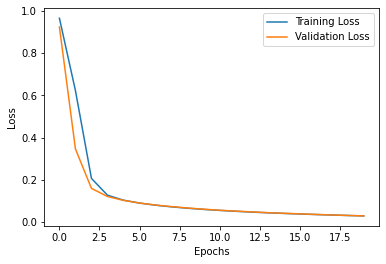

In [17]:
plt.plot(train_mse_loss, label='Training Loss')
plt.plot(test_mse_loss, label='Validation Loss')
# plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Determine Anomalies

Find MAE loss on the training data. Make the max MAE loss value in the training data as the reconstruction error threshold. If the reconstruction loss for a data point in the test set is greater than this reconstruction error threshold value then we will label this data point as an anomaly.

In [19]:
train_mae_loss = np.array([])
for X, y in train_loader:
        inputs = X.to(device)
        labels = y.detach().numpy()
        preds = model(inputs.float())
        preds = preds.detach().cpu().numpy()
        one_batch_train_mae_loss = np.mean(np.abs(preds - labels), axis=1)
        train_mae_loss = np.append(train_mae_loss, one_batch_train_mae_loss)

Text(0, 0.5, 'Number of Samples')

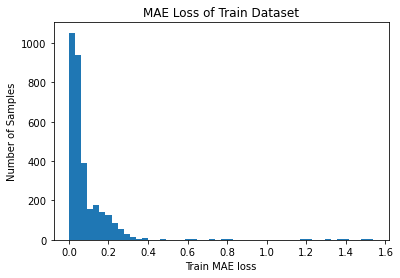

In [22]:
plt.hist(train_mae_loss, bins=50)
plt.title('MAE Loss of Train Dataset')
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')

In [23]:
threshold = np.max(train_mae_loss)
threshold

1.5386642217636108

## Test on Abnormal Sequence

In [24]:
# preprocess 
scaled_test = df_daily_jumpsup.copy()
scaled_test.loc[:, 'value'] = scaler.transform(scaled_test[['value']])

In [25]:
daily_anomaly = AccelerometerDataset(
    scaled_test,
    target=['value'],
    features=['value'],
    sequence_length=sequence_length
)

daily_anomaly_loader = DataLoader(daily_anomaly, batch_size=batch_size, shuffle=False)

X, y = next(iter(daily_anomaly_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([5, 30, 1])
Target shape: torch.Size([5, 1])


In [27]:
mae_loss_anomaly = np.array([])
for X, y in daily_anomaly_loader:
        inputs = X.to(device)
        labels = y.detach().numpy()
        preds = model(inputs.float())
        preds = preds.cpu().detach().numpy()
        one_batch_test_mae_loss = np.mean(np.abs(preds - labels), axis=1)
        mae_loss_anomaly = np.append(mae_loss_anomaly, one_batch_test_mae_loss)   

In [28]:
# Checking how the first sequence is learnt
anomalies = mae_loss_anomaly > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  84
Indices of anomaly samples:  (array([ 108, 2988, 2989, 3001, 3002, 3003, 3004, 3005, 3008, 3009, 3010,
       3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3021, 3022,
       3024, 3025, 3026, 3027, 3028, 3029, 3030, 3032, 3033, 3034, 3035,
       3036, 3037, 3038, 3039, 3041, 3042, 3043, 3044, 3045, 3047, 3048,
       3049, 3052, 3053, 3054, 3055, 3056, 3058, 3059, 3060, 3061, 3062,
       3063, 3064, 3065, 3067, 3068, 3069, 3070, 3071, 3072, 3074, 3075,
       3076, 3077, 3078, 3079, 3083, 3084, 3085, 3086, 3087, 3088, 3089,
       3091, 3092, 3093, 3094, 3095, 3096, 3852]),)


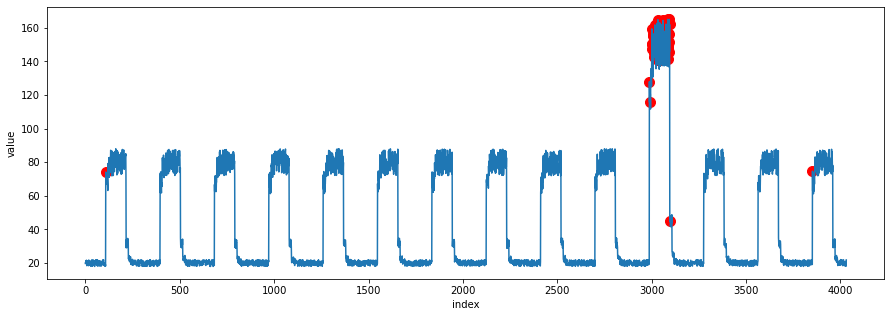

In [30]:
anomalous_data_indices = np.where(anomalies)
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots(figsize=(15, 5))
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.reset_index().plot.scatter(x = 'index', y = 'value', ax=ax, color="r", s=100)
plt.show()

Text(0, 0.5, 'Number of Samples')

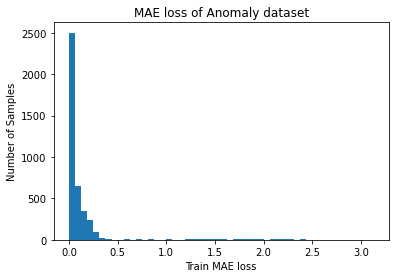

In [32]:
plt.hist(mae_loss_anomaly, bins=50)
plt.title('MAE loss of Anomaly dataset')
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')